# Task 3 - Training a VAE on MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

### a) Define the VAE model

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        # Standard deviation for decoder
        self.std = nn.Parameter(torch.ones(1))

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def generate_samples(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.decode(z)
        return samples

### b) Utility functions

In [3]:
# Function to calculate ELBO loss
def calculate_loss(x, x_recon, mu, logvar, std):
    recon_loss = F.binary_cross_entropy(x_recon, x.view(-1, input_dim), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Function for training the VAE
def train_vae(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for data, _ in dataloader:
        data = data.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        recon_data, mu, logvar = model(data)
        loss = calculate_loss(data, recon_data, mu, logvar, model.std)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

# Function for testing the VAE
def test_vae(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(-1, input_dim).to(device)
            recon_data, mu, logvar = model(data)
            loss = calculate_loss(data, recon_data, mu, logvar, model.std)
            total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

# Function to plot the latent representation
def plot_latent_representation(model, dataloader, device):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in dataloader:
            data = data.view(-1, input_dim).to(device)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu().numpy())
            labels.append(label.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.title('Latent Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Function to plot reconstructed digits
def plot_reconstructed_digits(model, dataloader, device, num_digits=15):
    model.eval()
    data, _ = next(iter(dataloader))
    data = data.view(-1, input_dim).to(device)

    with torch.no_grad():
        recon_data, _, _ = model(data)

    data = data.view(-1, 28, 28).cpu().numpy()
    recon_data = recon_data.view(-1, 28, 28).cpu().numpy()

    plt.figure(figsize=(10, 4))
    for i in range(num_digits):
        plt.subplot(3, num_digits, i + 1)
        plt.imshow(data[i], cmap='gray')
        plt.axis('off')
        plt.subplot(3, num_digits, num_digits + i + 1)
        plt.imshow(recon_data[i], cmap='gray')
        plt.axis('off')

    plt.suptitle('Reconstructed Digits')
    plt.show()

# Function to plot generated digits
def plot_generated_digits(model, num_samples=15):
    model.eval()
    with torch.no_grad():
        generated_samples = model.generate_samples(num_samples)
        generated_samples = generated_samples.view(-1, 28, 28).cpu().detach().numpy()

    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(generated_samples[i], cmap='gray')
        plt.axis('off')

    plt.suptitle('Generated Digits')
    plt.show()

# Function to plot the loss curve
def plot_loss_curve(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    epochs = len(train_losses)
    plt.plot(range(1, epochs+1), train_losses, label='Train')
    plt.plot(range(1, epochs+1), test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

### c) Part 1-4: Use the Adam optimiser with a learning rate of 0.001. Use a batch size of 128 for training.

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 17943737.36it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 51591011.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 13490736.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 7447431.11it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 1/50, Train Loss: 189.9288, Test Loss: 167.9023


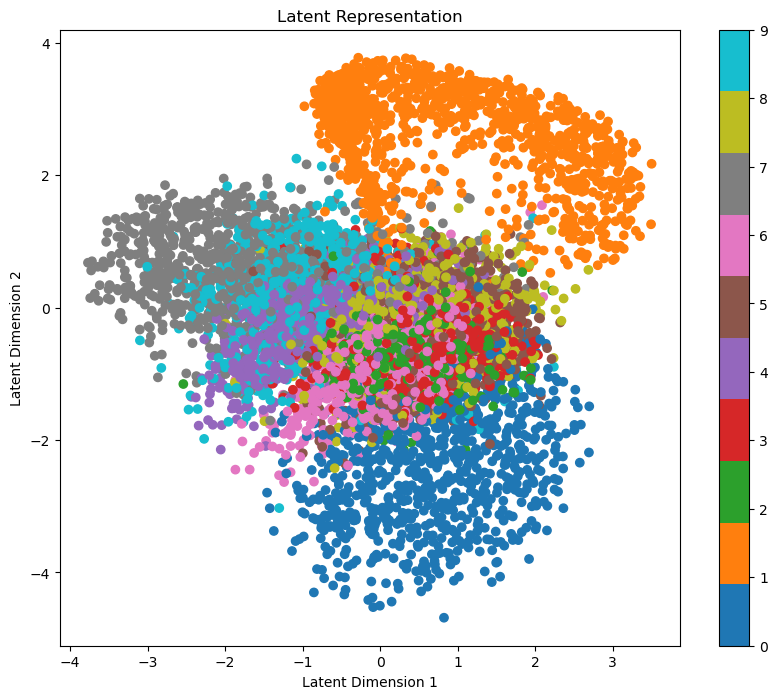

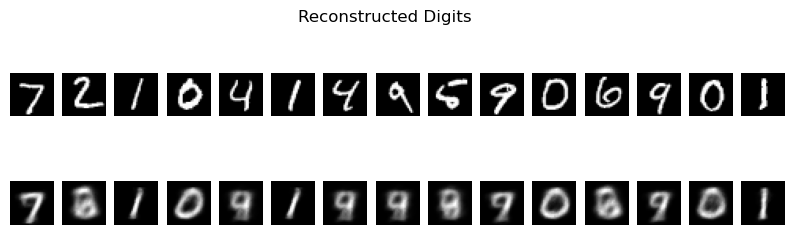

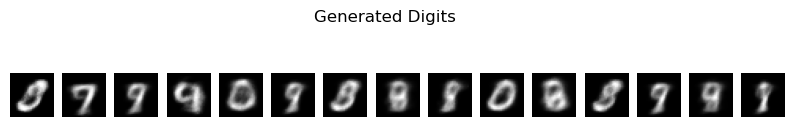

Epoch 2/50, Train Loss: 164.3905, Test Loss: 160.8772
Epoch 3/50, Train Loss: 157.7207, Test Loss: 156.0983
Epoch 4/50, Train Loss: 153.6965, Test Loss: 152.6070
Epoch 5/50, Train Loss: 150.8109, Test Loss: 150.1847


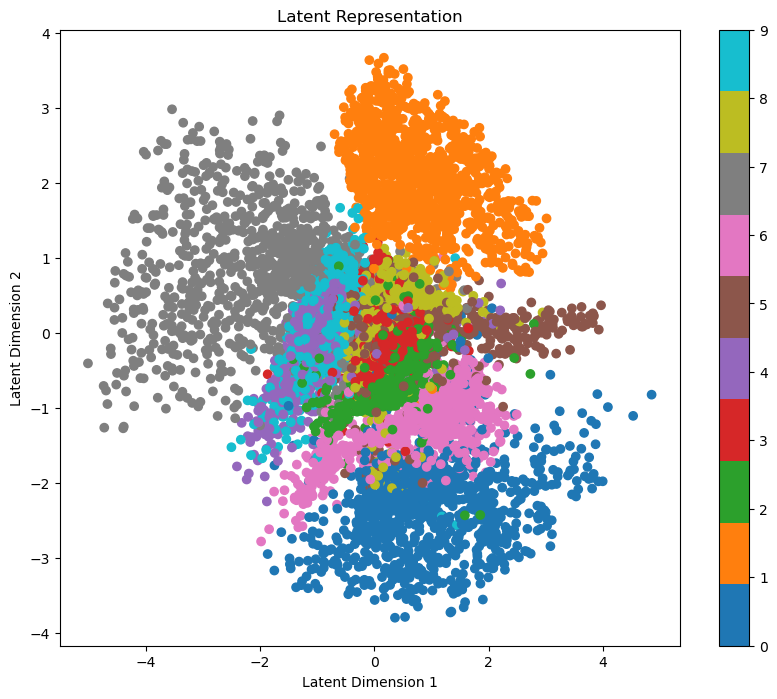

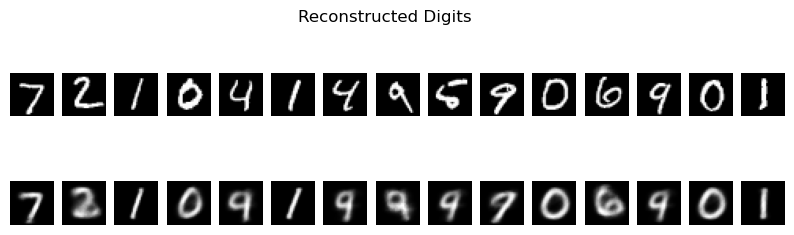

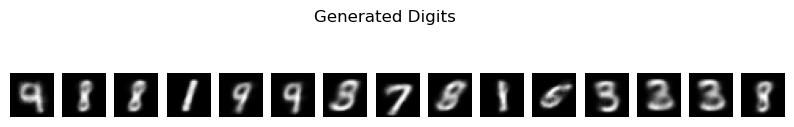

Epoch 6/50, Train Loss: 148.9552, Test Loss: 148.7967
Epoch 7/50, Train Loss: 147.5214, Test Loss: 147.6209
Epoch 8/50, Train Loss: 146.4810, Test Loss: 146.6869
Epoch 9/50, Train Loss: 145.4335, Test Loss: 146.4606
Epoch 10/50, Train Loss: 144.6303, Test Loss: 145.1767
Epoch 11/50, Train Loss: 143.9552, Test Loss: 144.5265
Epoch 12/50, Train Loss: 143.3922, Test Loss: 144.1072
Epoch 13/50, Train Loss: 142.9024, Test Loss: 144.1494
Epoch 14/50, Train Loss: 142.5958, Test Loss: 143.0192
Epoch 15/50, Train Loss: 142.0407, Test Loss: 142.9897
Epoch 16/50, Train Loss: 141.6326, Test Loss: 142.3686
Epoch 17/50, Train Loss: 141.4796, Test Loss: 142.3246
Epoch 18/50, Train Loss: 141.0632, Test Loss: 142.3911
Epoch 19/50, Train Loss: 140.9120, Test Loss: 142.3491
Epoch 20/50, Train Loss: 140.7956, Test Loss: 141.6595
Epoch 21/50, Train Loss: 140.4146, Test Loss: 141.8314
Epoch 22/50, Train Loss: 140.0585, Test Loss: 141.3770
Epoch 23/50, Train Loss: 139.8111, Test Loss: 141.3815
Epoch 24/50, T

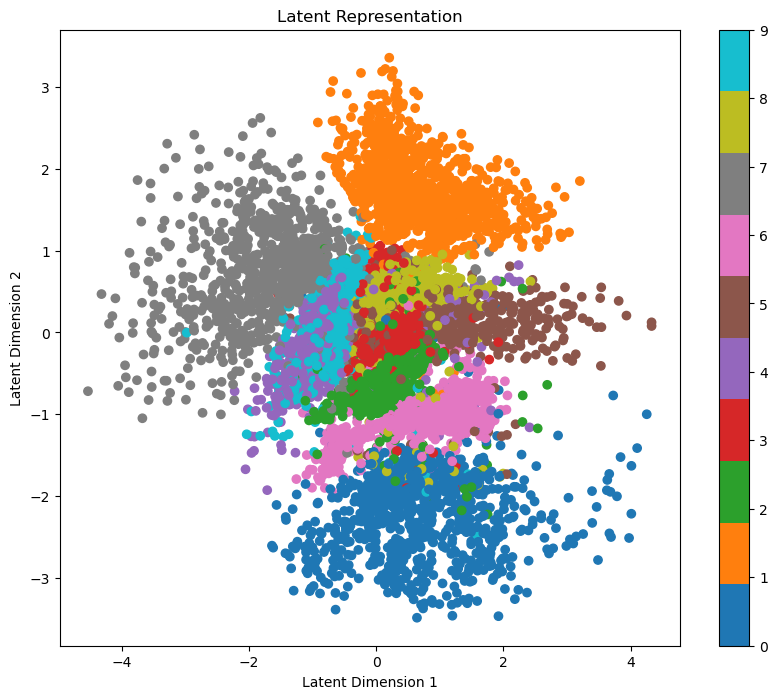

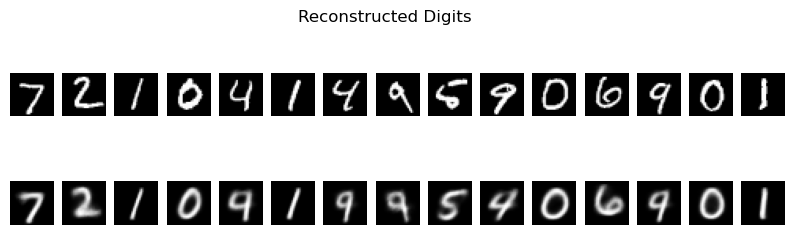

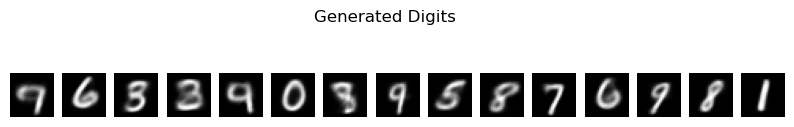

Epoch 26/50, Train Loss: 139.3369, Test Loss: 140.7431
Epoch 27/50, Train Loss: 139.2306, Test Loss: 140.8094
Epoch 28/50, Train Loss: 138.9898, Test Loss: 140.2944
Epoch 29/50, Train Loss: 138.7743, Test Loss: 140.4488
Epoch 30/50, Train Loss: 138.6160, Test Loss: 140.2041
Epoch 31/50, Train Loss: 138.3971, Test Loss: 140.4944
Epoch 32/50, Train Loss: 138.5541, Test Loss: 140.7706
Epoch 33/50, Train Loss: 138.5371, Test Loss: 140.0778
Epoch 34/50, Train Loss: 137.9814, Test Loss: 139.5659
Epoch 35/50, Train Loss: 138.5622, Test Loss: 140.3582
Epoch 36/50, Train Loss: 138.2804, Test Loss: 139.9239
Epoch 37/50, Train Loss: 137.7960, Test Loss: 140.3235
Epoch 38/50, Train Loss: 137.9485, Test Loss: 139.4692
Epoch 39/50, Train Loss: 137.8168, Test Loss: 139.8715
Epoch 40/50, Train Loss: 137.7737, Test Loss: 139.7992
Epoch 41/50, Train Loss: 137.4441, Test Loss: 139.6190
Epoch 42/50, Train Loss: 137.4127, Test Loss: 139.4820
Epoch 43/50, Train Loss: 137.1874, Test Loss: 139.5450
Epoch 44/5

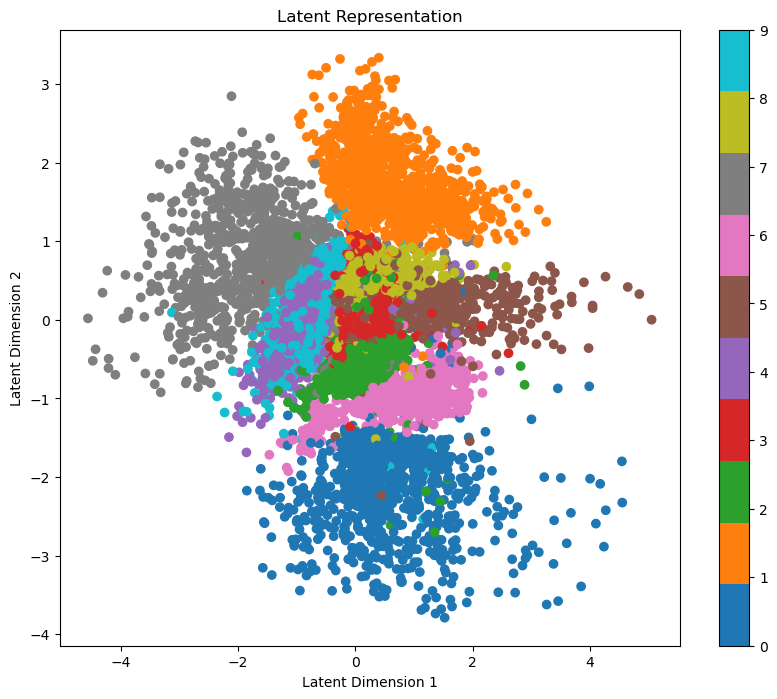

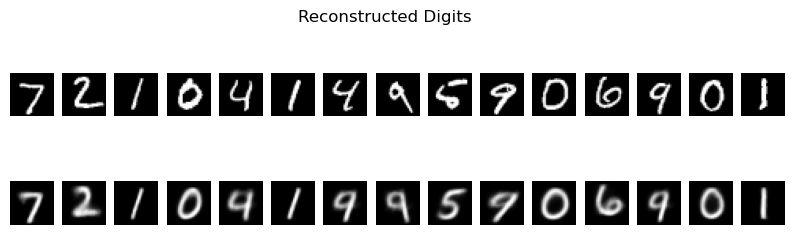

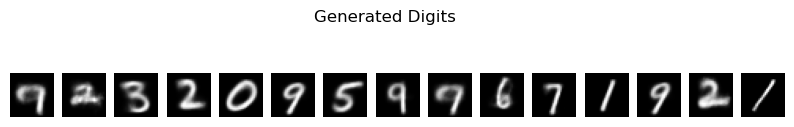

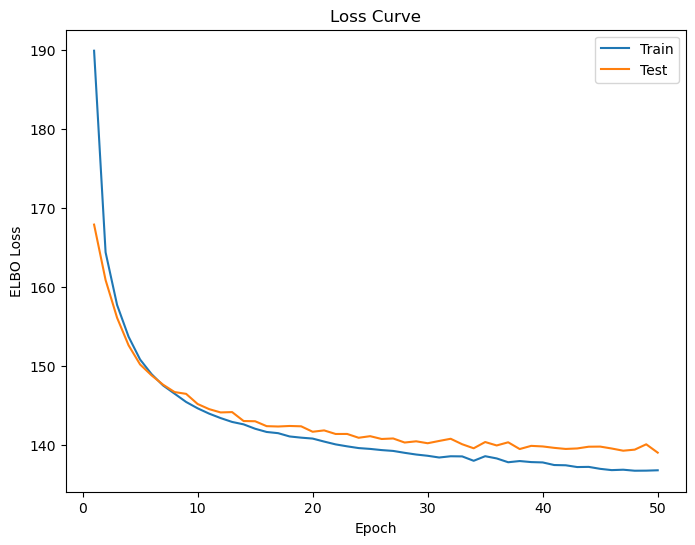

In [4]:
# Set the variables
input_dim = 784  # Number of input dimensions (28x28)
latent_dim = 2  # Dimension of the latent space
hidden_dim = 256  # Number of hidden units in the encoder and decoder
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 128  # Batch size for training
num_epochs = 50  # Number of epochs

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the MNIST dataset
train_dataset = MNIST(".", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(".", train=False, download=True, transform=ToTensor())

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the VAE model
vae = VAE(input_dim, latent_dim, hidden_dim).to(device)

# Set up the optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Lists to store the training and test losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = train_vae(vae, train_loader, optimizer, device)
    test_loss = test_vae(vae, test_loader, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Perform experiments after specific epochs
    if epoch == 0 or epoch == 4 or epoch == 24 or epoch == 49 or epoch == num_epochs-1:
        # (a) Plot the latent representation
        plot_latent_representation(vae, test_loader, device)

        # (b) Plot reconstructed digits
        plot_reconstructed_digits(vae, test_loader, device)

        # (c) Plot generated digits
        plot_generated_digits(vae)
# Plot the loss curve
plot_loss_curve(train_losses, test_losses)

## d) Part 5: Train the VAE using a 32-dimensional latent space

Epoch 1/50, Train Loss: 189.5826, Test Loss: 153.5735
Epoch 2/50, Train Loss: 139.3764, Test Loss: 128.6674
Epoch 3/50, Train Loss: 124.3462, Test Loss: 119.3383
Epoch 4/50, Train Loss: 117.7995, Test Loss: 114.9322
Epoch 5/50, Train Loss: 114.4422, Test Loss: 112.3441
Epoch 6/50, Train Loss: 112.1613, Test Loss: 110.4541
Epoch 7/50, Train Loss: 110.5345, Test Loss: 109.2327
Epoch 8/50, Train Loss: 109.1240, Test Loss: 108.0733
Epoch 9/50, Train Loss: 108.0264, Test Loss: 106.9726
Epoch 10/50, Train Loss: 107.0690, Test Loss: 106.3572
Epoch 11/50, Train Loss: 106.2691, Test Loss: 105.3730
Epoch 12/50, Train Loss: 105.5850, Test Loss: 104.8545
Epoch 13/50, Train Loss: 104.9805, Test Loss: 104.5624
Epoch 14/50, Train Loss: 104.4524, Test Loss: 104.3597
Epoch 15/50, Train Loss: 104.0799, Test Loss: 103.8800
Epoch 16/50, Train Loss: 103.7175, Test Loss: 103.5896
Epoch 17/50, Train Loss: 103.3649, Test Loss: 103.3145
Epoch 18/50, Train Loss: 103.0212, Test Loss: 103.0183
Epoch 19/50, Train 

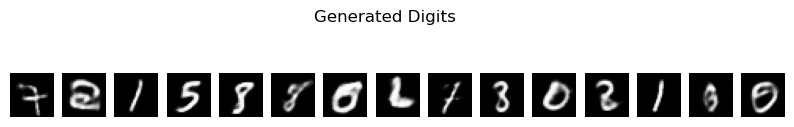

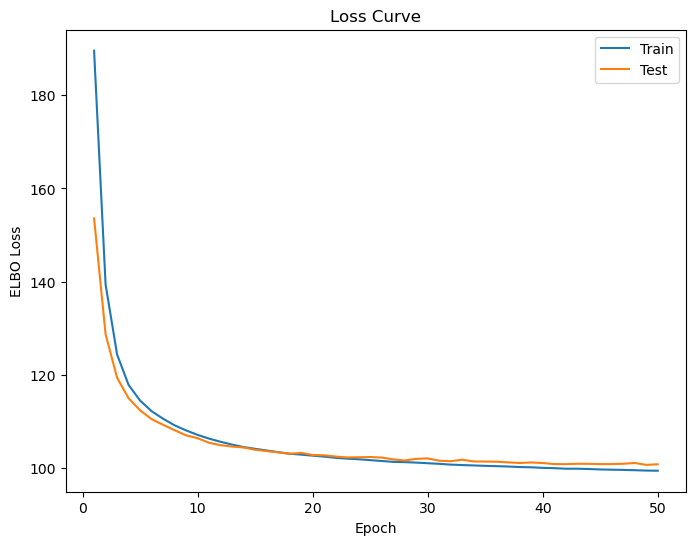

In [5]:
# Set the variables
input_dim = 784  # Number of input dimensions (28x28)
latent_dim = 32  # Dimension of the latent space
hidden_dim = 256  # Number of hidden units in the encoder and decoder
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 128  # Batch size for training
num_epochs = 50  # Number of epochs

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the MNIST dataset
train_dataset = MNIST(".", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(".", train=False, download=True, transform=ToTensor())

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the VAE model
vae = VAE(input_dim, latent_dim, hidden_dim).to(device)

# Set up the optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Lists to store the training and test losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = train_vae(vae, train_loader, optimizer, device)
    test_loss = test_vae(vae, test_loader, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# (a) Compare 15 generated digits
print("Generated Digits (32-dimensional Latent Space):")
plot_generated_digits(vae)

# (b) Compare the loss curve
plot_loss_curve(train_losses, test_losses)

## ~ The End! ~